In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 73.3MB/s]


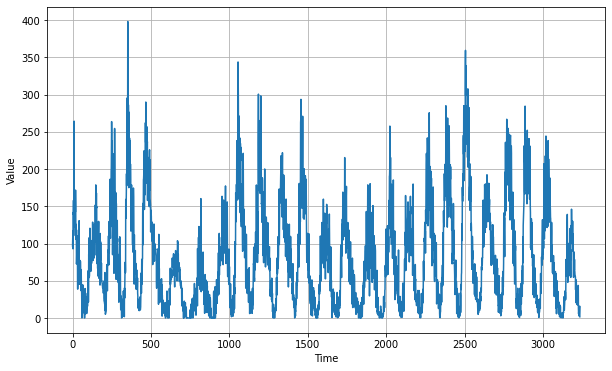

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

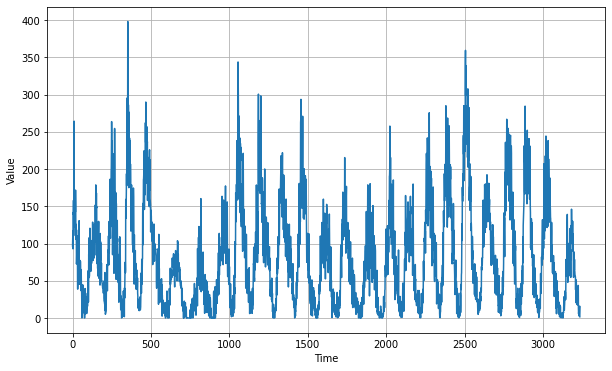

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 16s 97ms/step - loss: 64.0789 - mae: 64.5750 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 53ms/step - loss: 63.6420 - mae: 64.1386 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 51ms/step - loss: 63.0131 - mae: 63.5102 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 58ms/step - loss: 62.2768 - mae: 62.7743 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 54ms/step - loss: 61.4701 - mae: 61.9675 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 48ms/step - loss: 60.5916 - mae: 61.0890 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 42ms/step - loss: 59.6484 - mae: 60.1459 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============

(1e-08, 0.0001, 0.0, 60.0)

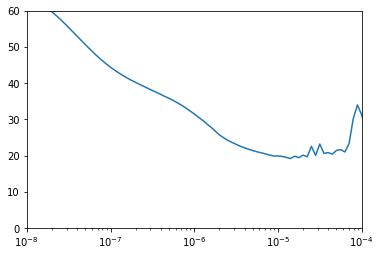

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
# Added one dense layer with 20 units. Changed number of units for LSTM layer to 30.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=400)

Epoch 1/400
30/30 [==============================] - 5s 19ms/step - loss: 44.8144 - mae: 45.3113
Epoch 2/400
30/30 [==============================] - 1s 20ms/step - loss: 26.1247 - mae: 26.6194
Epoch 3/400
30/30 [==============================] - 1s 36ms/step - loss: 22.4167 - mae: 22.9106
Epoch 4/400
30/30 [==============================] - 1s 30ms/step - loss: 20.8123 - mae: 21.3058
Epoch 5/400
30/30 [==============================] - 1s 19ms/step - loss: 20.8432 - mae: 21.3366
Epoch 6/400
30/30 [==============================] - 1s 19ms/step - loss: 19.6092 - mae: 20.1022
Epoch 7/400
30/30 [==============================] - 1s 21ms/step - loss: 20.1205 - mae: 20.6134
Epoch 8/400
30/30 [==============================] - 1s 20ms/step - loss: 19.6990 - mae: 20.1919
Epoch 9/400
30/30 [==============================] - 1s 20ms/step - loss: 19.2747 - mae: 19.7672
Epoch 10/400
30/30 [==============================] - 1s 22ms/step - loss: 18.5469 - mae: 19.0392
Epoch 11/400
30/30 [=========

In [20]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

101/101 [==============================] - 1s 7ms/step


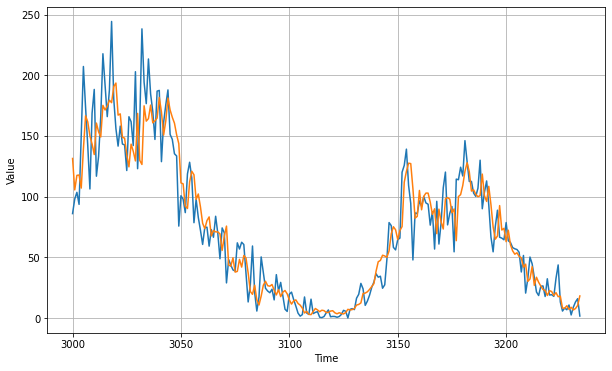

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
# mae keeps on changing everytime i run the code. Last time i Ran the code mae was 14.570884

14.570884

<Figure size 432x288 with 0 Axes>

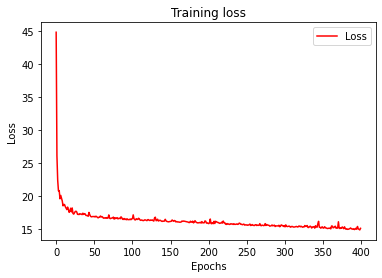

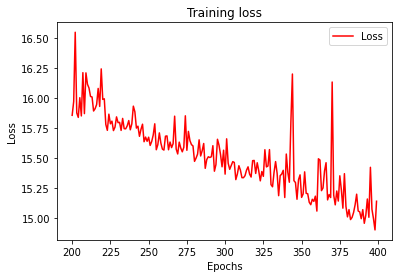

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [24]:
print(rnn_forecast)

[131.4169    105.5166    117.50995   117.792     107.016136  139.27136
 166.55188   161.60057   150.04654   143.38397   134.65009   160.5863
 153.36795   149.11067   175.17955   171.37611   174.48026   179.47884
 177.40204   190.60516   193.56502   167.13231   168.16525   148.81496
 148.19487   134.49323   124.51028   143.21603   137.33763   129.40242
 168.52708   129.85735   126.47811   174.805     162.17986   164.25893
 175.38985   160.77254   162.45894   164.6838    181.66217   169.63864
 150.70134   162.32286   181.22998   171.37787   165.42331   160.51671
 151.0043    143.62311   111.29732   110.52117    92.108284   90.198425
 112.0646    120.88406   117.98335    97.65724   102.13856    91.47885
  78.01823    73.61278    80.25161    83.271805   67.62323    72.102646
  70.93619    70.87333    69.28299    55.67568    67.38716    75.69695
  43.65796    42.645752   49.588524   37.784664   38.373653   48.267822
  41.928757   51.475883   49.42396    37.13965    21.809875   19.482113
  2

In [49]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 3000

In [50]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [51]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [84]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 13ms/step - loss: 61.7044 - mae: 62.2013 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 61.5795 - mae: 62.0766 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 13ms/step - loss: 61.3964 - mae: 61.8938 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 61.1806 - mae: 61.6783 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 18ms/step - loss: 60.9379 - mae: 61.4357 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 17ms/step - loss: 60.6665 - mae: 61.1643 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 60.3644 - mae: 60.8622 - lr: 1.9953e-08
Epoch 8/100
12/12 [===============

(1e-08, 0.0001, 0.0, 60.0)

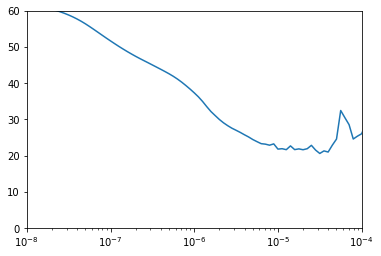

In [85]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [91]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=400)

Epoch 1/400
30/30 [==============================] - 4s 15ms/step - loss: 67.1948 - mae: 67.6932
Epoch 2/400
30/30 [==============================] - 1s 12ms/step - loss: 37.2075 - mae: 37.7035
Epoch 3/400
30/30 [==============================] - 1s 12ms/step - loss: 26.8090 - mae: 27.3038
Epoch 4/400
30/30 [==============================] - 1s 12ms/step - loss: 24.2034 - mae: 24.6975
Epoch 5/400
30/30 [==============================] - 1s 13ms/step - loss: 22.3434 - mae: 22.8369
Epoch 6/400
30/30 [==============================] - 1s 12ms/step - loss: 21.5771 - mae: 22.0706
Epoch 7/400
30/30 [==============================] - 1s 19ms/step - loss: 21.0702 - mae: 21.5637
Epoch 8/400
30/30 [==============================] - 1s 17ms/step - loss: 20.8301 - mae: 21.3235
Epoch 9/400
30/30 [==============================] - 1s 12ms/step - loss: 20.3626 - mae: 20.8560
Epoch 10/400
30/30 [==============================] - 1s 11ms/step - loss: 20.1983 - mae: 20.6919
Epoch 11/400
30/30 [=========

In [92]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

101/101 [==============================] - 1s 7ms/step


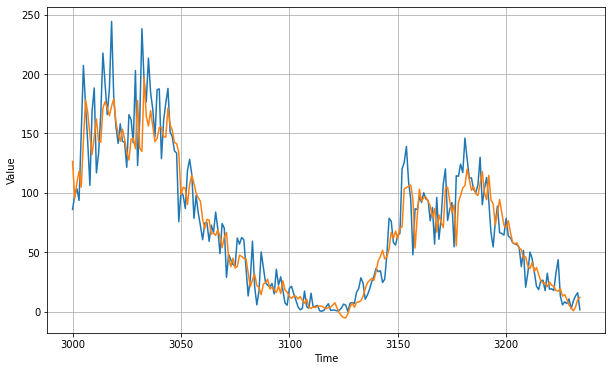

In [93]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [94]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
# mae at last execution was 14.342

14.342647

<Figure size 432x288 with 0 Axes>

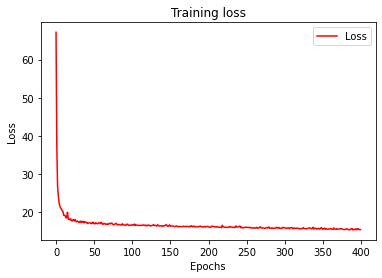

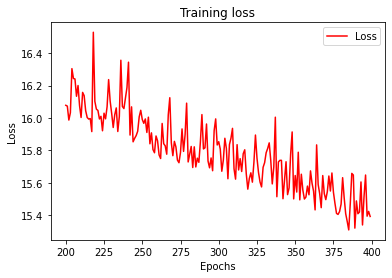

<Figure size 432x288 with 0 Axes>

In [95]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [96]:
print(rnn_forecast)

[126.49473    95.54988   108.487785  118.13004   104.70577   144.05222
 178.3657    167.56087   148.45126   132.1642    146.9634    162.24255
 143.53543   142.59293   171.3522    176.76788   171.44208   164.89096
 173.18097   179.09402   159.69044   149.736     143.43057   153.63576
 145.30266   134.39622   127.645325  145.20972   145.87743   137.15665
 177.70612   137.59654   134.88417   197.48946   164.77222   156.30272
 169.15584   155.86987   143.09895   145.81444   154.82932   155.12114
 147.26784   146.82925   171.3532    157.17094   152.63548   142.39357
 141.4587    133.86162    98.37462   104.58648   103.91295    90.20502
 107.16631   114.86933   107.970276   99.55794    95.94562    92.80442
  77.69493    70.02832    77.70742    77.0043     65.27551    66.212555
  64.147575   69.01433    62.89839    53.797455   62.824535   66.57422
  45.224888   37.862415   45.032223   36.690678   38.094227   47.576492
  46.41032    44.75413    44.48254    32.77574    20.955545   26.931208
  3